# 1. Import Dependencies and Data

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [ ]:
!pip list

In [38]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [39]:
# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [40]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

In [41]:
ds.as_numpy_iterator().next()['label']

2023-07-19 16:30:22.417287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:30:22.417478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-19 16:30:22.439782: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

2

# 2. Viz Data and Build Dataset

In [42]:
# Do some data transformation
import numpy as np

In [43]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

2023-07-19 16:30:23.290560: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [44]:
# Getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

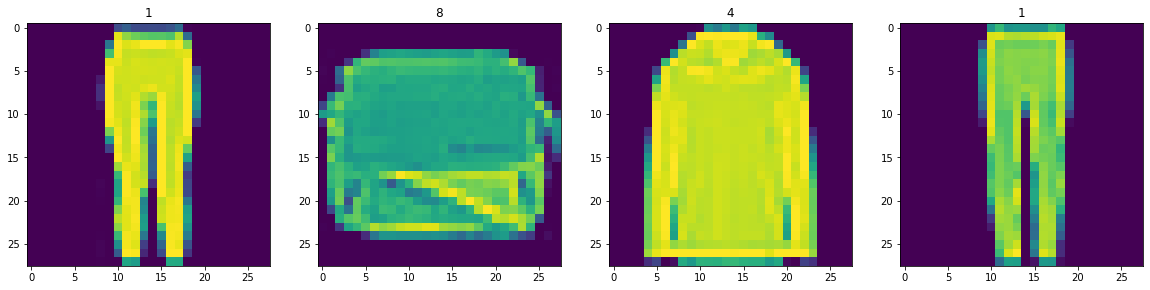

In [45]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [46]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [47]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [48]:
ds.as_numpy_iterator().next().shape

2023-07-19 16:30:24.196481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-19 16:30:24.196729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


(128, 28, 28, 1)

# 3. Build Neural Network

### 3.1 Import Modelling Components

In [49]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [50]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [51]:
generator = build_generator()

In [52]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [53]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 11ms/step


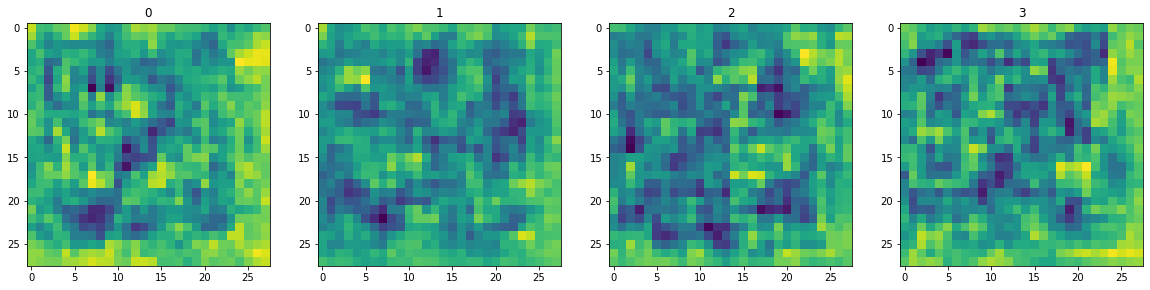

In [54]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [55]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [56]:
discriminator = build_discriminator()

In [57]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [58]:
img = img[0]

In [59]:
img.shape

(28, 1)

In [60]:
discriminator.predict(img)

ValueError: in user code:

    File "/home/dglick/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/dglick/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dglick/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/dglick/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/dglick/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/dglick/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).
    
    Input 0 of layer "conv2d_14" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer 'sequential_3' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
      • training=False
      • mask=None


# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [61]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [62]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [63]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [64]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [65]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [66]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [67]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [68]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train 

In [69]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=200, callbacks=[ModelMonitor()])

Epoch 1/200


2023-07-19 16:30:35.855126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 16s 30ms/step - d_loss: 0.4492 - g_loss: 1.1799
Epoch 2/200
469/469 [==============================] - 14s 30ms/step - d_loss: 0.6560 - g_loss: 0.9918
Epoch 3/200
469/469 [==============================] - 14s 30ms/step - d_loss: 0.6591 - g_loss: 0.7361
Epoch 4/200
469/469 [==============================] - 14s 30ms/step - d_loss: 0.7031 - g_loss: 0.5541
Epoch 5/200
469/469 [==============================] - 14s 30ms/step - d_loss: 0.6934 - g_loss: 0.6217
Epoch 6/200
469/469 [==============================] - 14s 30ms/step - d_loss: 0.6896 - g_loss: 0.6327
Epoch 7/200
469/469 [==============================] - 14s 30ms/step - d_loss: 0.6962 - g_loss: 0.6302
Epoch 8/200
469/469 [==============================] - 14s 30ms/step - d_loss: 0.6933 - g_loss: 0.6483
Epoch 9/200
469/469 [==============================] - 14s 30ms/step - d_loss: 0.6951 - g_loss: 0.6452
Epoch 10/200
469/469 [==============================] - 14s 29ms/step - d_loss: 0.691

KeyboardInterrupt: 

### 4.4 Review Performance

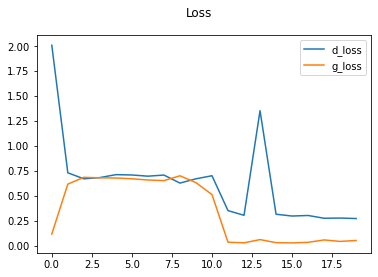

In [33]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [36]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 83ms/step


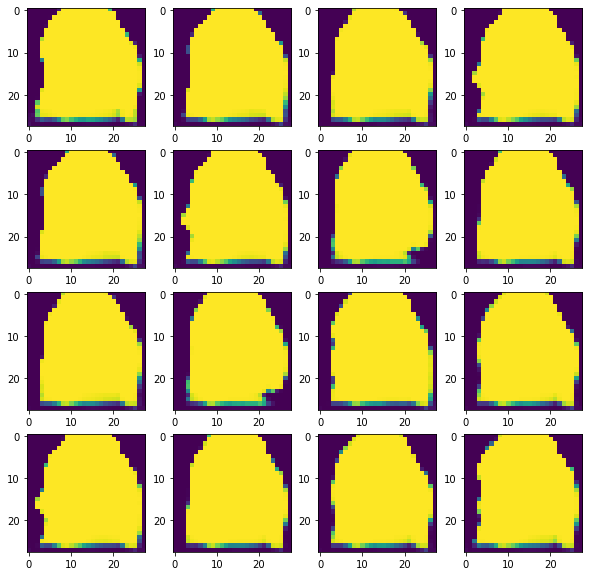

In [37]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')